DBSCANGroup takes a group of stars and gives them a label which identifies them as part of a group 

https://photutils.readthedocs.io/en/stable/grouping.html
https://photutils.readthedocs.io/en/stable/api/photutils.psf.DAOGroup.html#photutils.psf.DAOGroup

In [1]:
# STUFF FOR PLOTTING AND ECLIPSE IMAGE INFO
# for images too (also will use mpl)

%matplotlib notebook
import numpy as np
import fitsio
from astropy.io import fits
import numpy.ma as ma
from gPhoton.reference import eclipse_to_paths
from gPhoton.coadd import zero_flag_and_edge
from photutils.aperture import CircularAperture
from photutils.utils import make_random_cmap
import matplotlib as mpl
import matplotlib.pyplot as plt
from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse

import pandas as pd 

# info 
eclipse, band, depth, compression = 23417, "NUV", 30, "rice"

galex_file_paths = eclipse_to_paths(
    eclipse, '/home/bekah/gphoton_working/test_data', depth, compression
)

sources = pd.read_csv("23417_sources_0th_r1_5px.csv")


# image to hdul 
%time hdul = fitsio.FITS(galex_file_paths[band]['image'])
%time cnt, flag, edge = [hdu.read() for hdu in hdul[1:4]]

# masking cnt image
masked_cnt = zero_flag_and_edge(cnt, flag, edge)


# clipping 
def centile_clip(image, centiles=(1, 99)):
    """
    simple clipping function that clips values above and below a given
    percentile range
    """
    finite = np.ma.masked_invalid(image)
    bounds = np.percentile(finite[~finite.mask].data, centiles)
    result = np.ma.clip(finite, *bounds)
    
    if isinstance(image, np.ma.MaskedArray):
        
        return result
    
    return result.data

CPU times: user 334 µs, sys: 79 µs, total: 413 µs
Wall time: 417 µs
CPU times: user 139 ms, sys: 19.7 ms, total: 158 ms
Wall time: 158 ms


In [2]:
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))

from astropy.table import QTable, Table, Column 

starlist = Table()

x_0 = list(zip(*positions))[0]
y_0 = list(zip(*positions))[1]

starlist['x_0'] = x_0
starlist['y_0'] = y_0

In [3]:
from photutils.psf.groupstars import DBSCANGroup

fwhm_db = 10

%time dbscan_group = DBSCANGroup(crit_separation=2.5 * fwhm_db)

%time dbsc_star_groups = dbscan_group(starlist)

dbsc_star_groups_pd = dbsc_star_groups.to_pandas().groupby(['group_id'])

dbsc_star_groups = dbsc_star_groups.group_by('group_id')
 
dbsc_star_groups_count = dbsc_star_groups_pd.size()

dbsc_star_groups_count.sort_values(ascending=False)

CPU times: user 14 µs, sys: 3 µs, total: 17 µs
Wall time: 21.7 µs
CPU times: user 237 ms, sys: 97 µs, total: 237 ms
Wall time: 236 ms


group_id
18      15134
816       164
313        61
11         35
269        30
        ...  
435         1
440         1
441         1
442         1
1016        1
Length: 1016, dtype: int64

In [4]:
# calculating ellipses for DBSC group

extended_dict_dbsc = [] 

for i, group in enumerate(dbsc_star_groups.groups):
    if len(group) > 20: 
        xypos = np.transpose([group['x_0'], group['y_0']])

        ell = EllipseModel()

        ell.estimate(xypos)
        print(np.mean(ell.residuals(xypos)))
        xc, yc, a, b, theta = ell.params
        extended_dict_dbsc.append({'xc':xc, 'yc':yc, 'a':a+np.mean(ell.residuals(xypos)), 'b':b+np.mean(ell.residuals(xypos)), 'theta':theta})

        print("center = ",  (xc, yc))
        print("angle of rotation = ",  theta)
        print("axes = ", (a,b))
        
extended_sources_dbsc = pd.DataFrame.from_dict(extended_dict_dbsc)

14.48744743328824
center =  (1182.5981982390642, 195.1193426036515)
angle of rotation =  1.654579350972934
axes =  (32.90197553285454, 70.08534021412355)
206.18770651747766
center =  (1582.6612757211615, 1623.5460644460256)
angle of rotation =  2.1754618754531263
axes =  (1120.049778126337, 530.2617941052624)
16.88864573155549
center =  (2887.53374938306, 1034.310777918698)
angle of rotation =  0.0476808264653722
axes =  (50.61893162689199, 74.38299872517179)
17.89563946651203
center =  (2758.1886889378625, 1159.149748197998)
angle of rotation =  0.2560287274855419
axes =  (63.346074502072355, 70.03726026540988)
8.670437563678469
center =  (2985.127256486947, 1124.9963630618436)
angle of rotation =  1.0489341574466344
axes =  (71.09382639889695, 20.898462816207463)
25.481127844725425
center =  (2604.494685048651, 2580.1298225405985)
angle of rotation =  2.1087595204643397
axes =  (106.13662691112012, 62.49395436751916)
8.456811610576295
center =  (2359.1759349573354, 2861.3378258669786

[0 7]


<IPython.core.display.Javascript object>


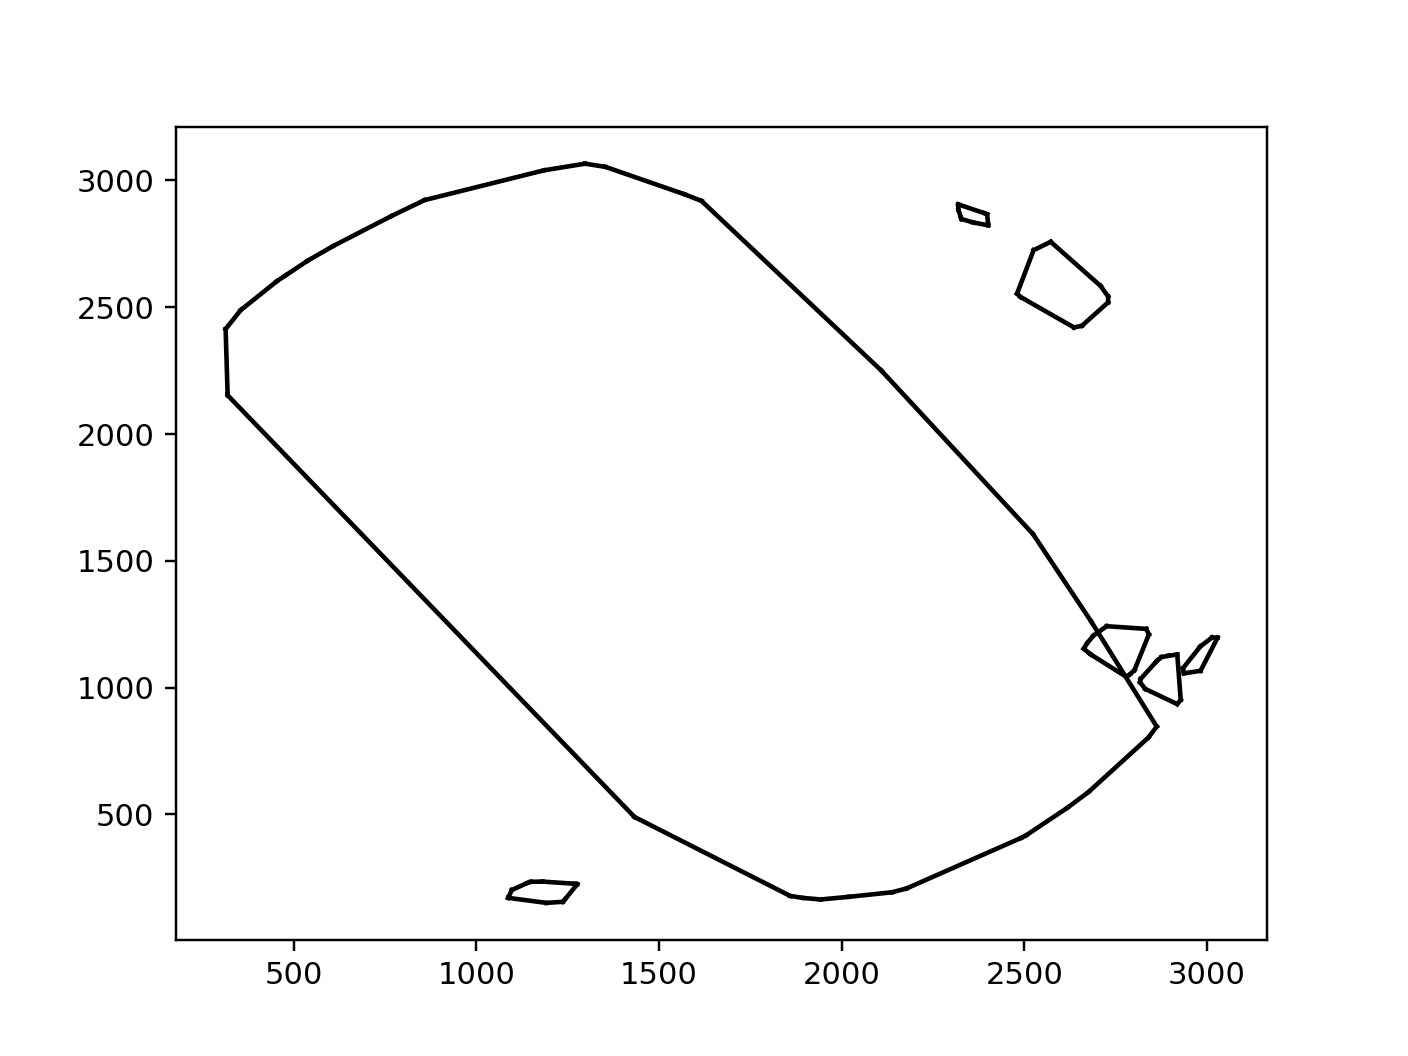

[1 0]
[20  7]
[34 33]
[ 5 29]
[5 1]
[30 33]
[30 20]
[31 29]
[31 34]
[731   6]
[15127 15133]
[15127 14993]
[ 7344 12269]
[14986 12269]
[11606   731]
[13711 13233]
[14569 14434]
[4649 2466]
[4649 7344]
[15131 15133]
[11642 13233]
[11642 11606]
[2258 2466]
[2258 1222]
[ 900 1222]
[ 26 440]
[26 16]
[14199 13711]
[14860 14993]
[14860 14569]
[15024 14986]
[15024 15131]
[461 440]
[461 900]
[1 6]
[1 0]
[ 4 16]
[4 0]
[14276 14434]
[14276 14199]
[29  1]
[0 1]
[15 12]
[28 29]
[28 27]
[ 5 12]
[5 0]
[24 15]
[25 27]
[25 24]
[19  0]
[ 2 52]
[51 60]
[59 52]
[59 60]
[24 32]
[24 19]
[1 0]
[1 2]
[40 32]
[40 51]
[0 5]
[ 1 20]
[1 0]
[16  5]
[19 20]
[19 16]
[160  54]
[160 163]
[ 88 163]
[44 54]
[44  0]
[ 1 26]
[1 0]
[45 26]
[45 88]
[1 0]
[12  0]
[4 1]
[14 22]
[14 12]
[19 22]
[5 4]
[ 5 19]


In [5]:
# using convex hull to find border of group 

from scipy.spatial import ConvexHull, convex_hull_plot_2d

for i, group in enumerate(dbsc_star_groups.groups):
    if len(group) > 20: 
        xypos = np.transpose([group['x_0'], group['y_0']])
        hull = ConvexHull(xypos)
        for simplex in hull.simplices:
            print(simplex)
            #plt.plot(xypos[simplex, 0], xypos[simplex, 1], 'k-')

<IPython.core.display.Javascript object>


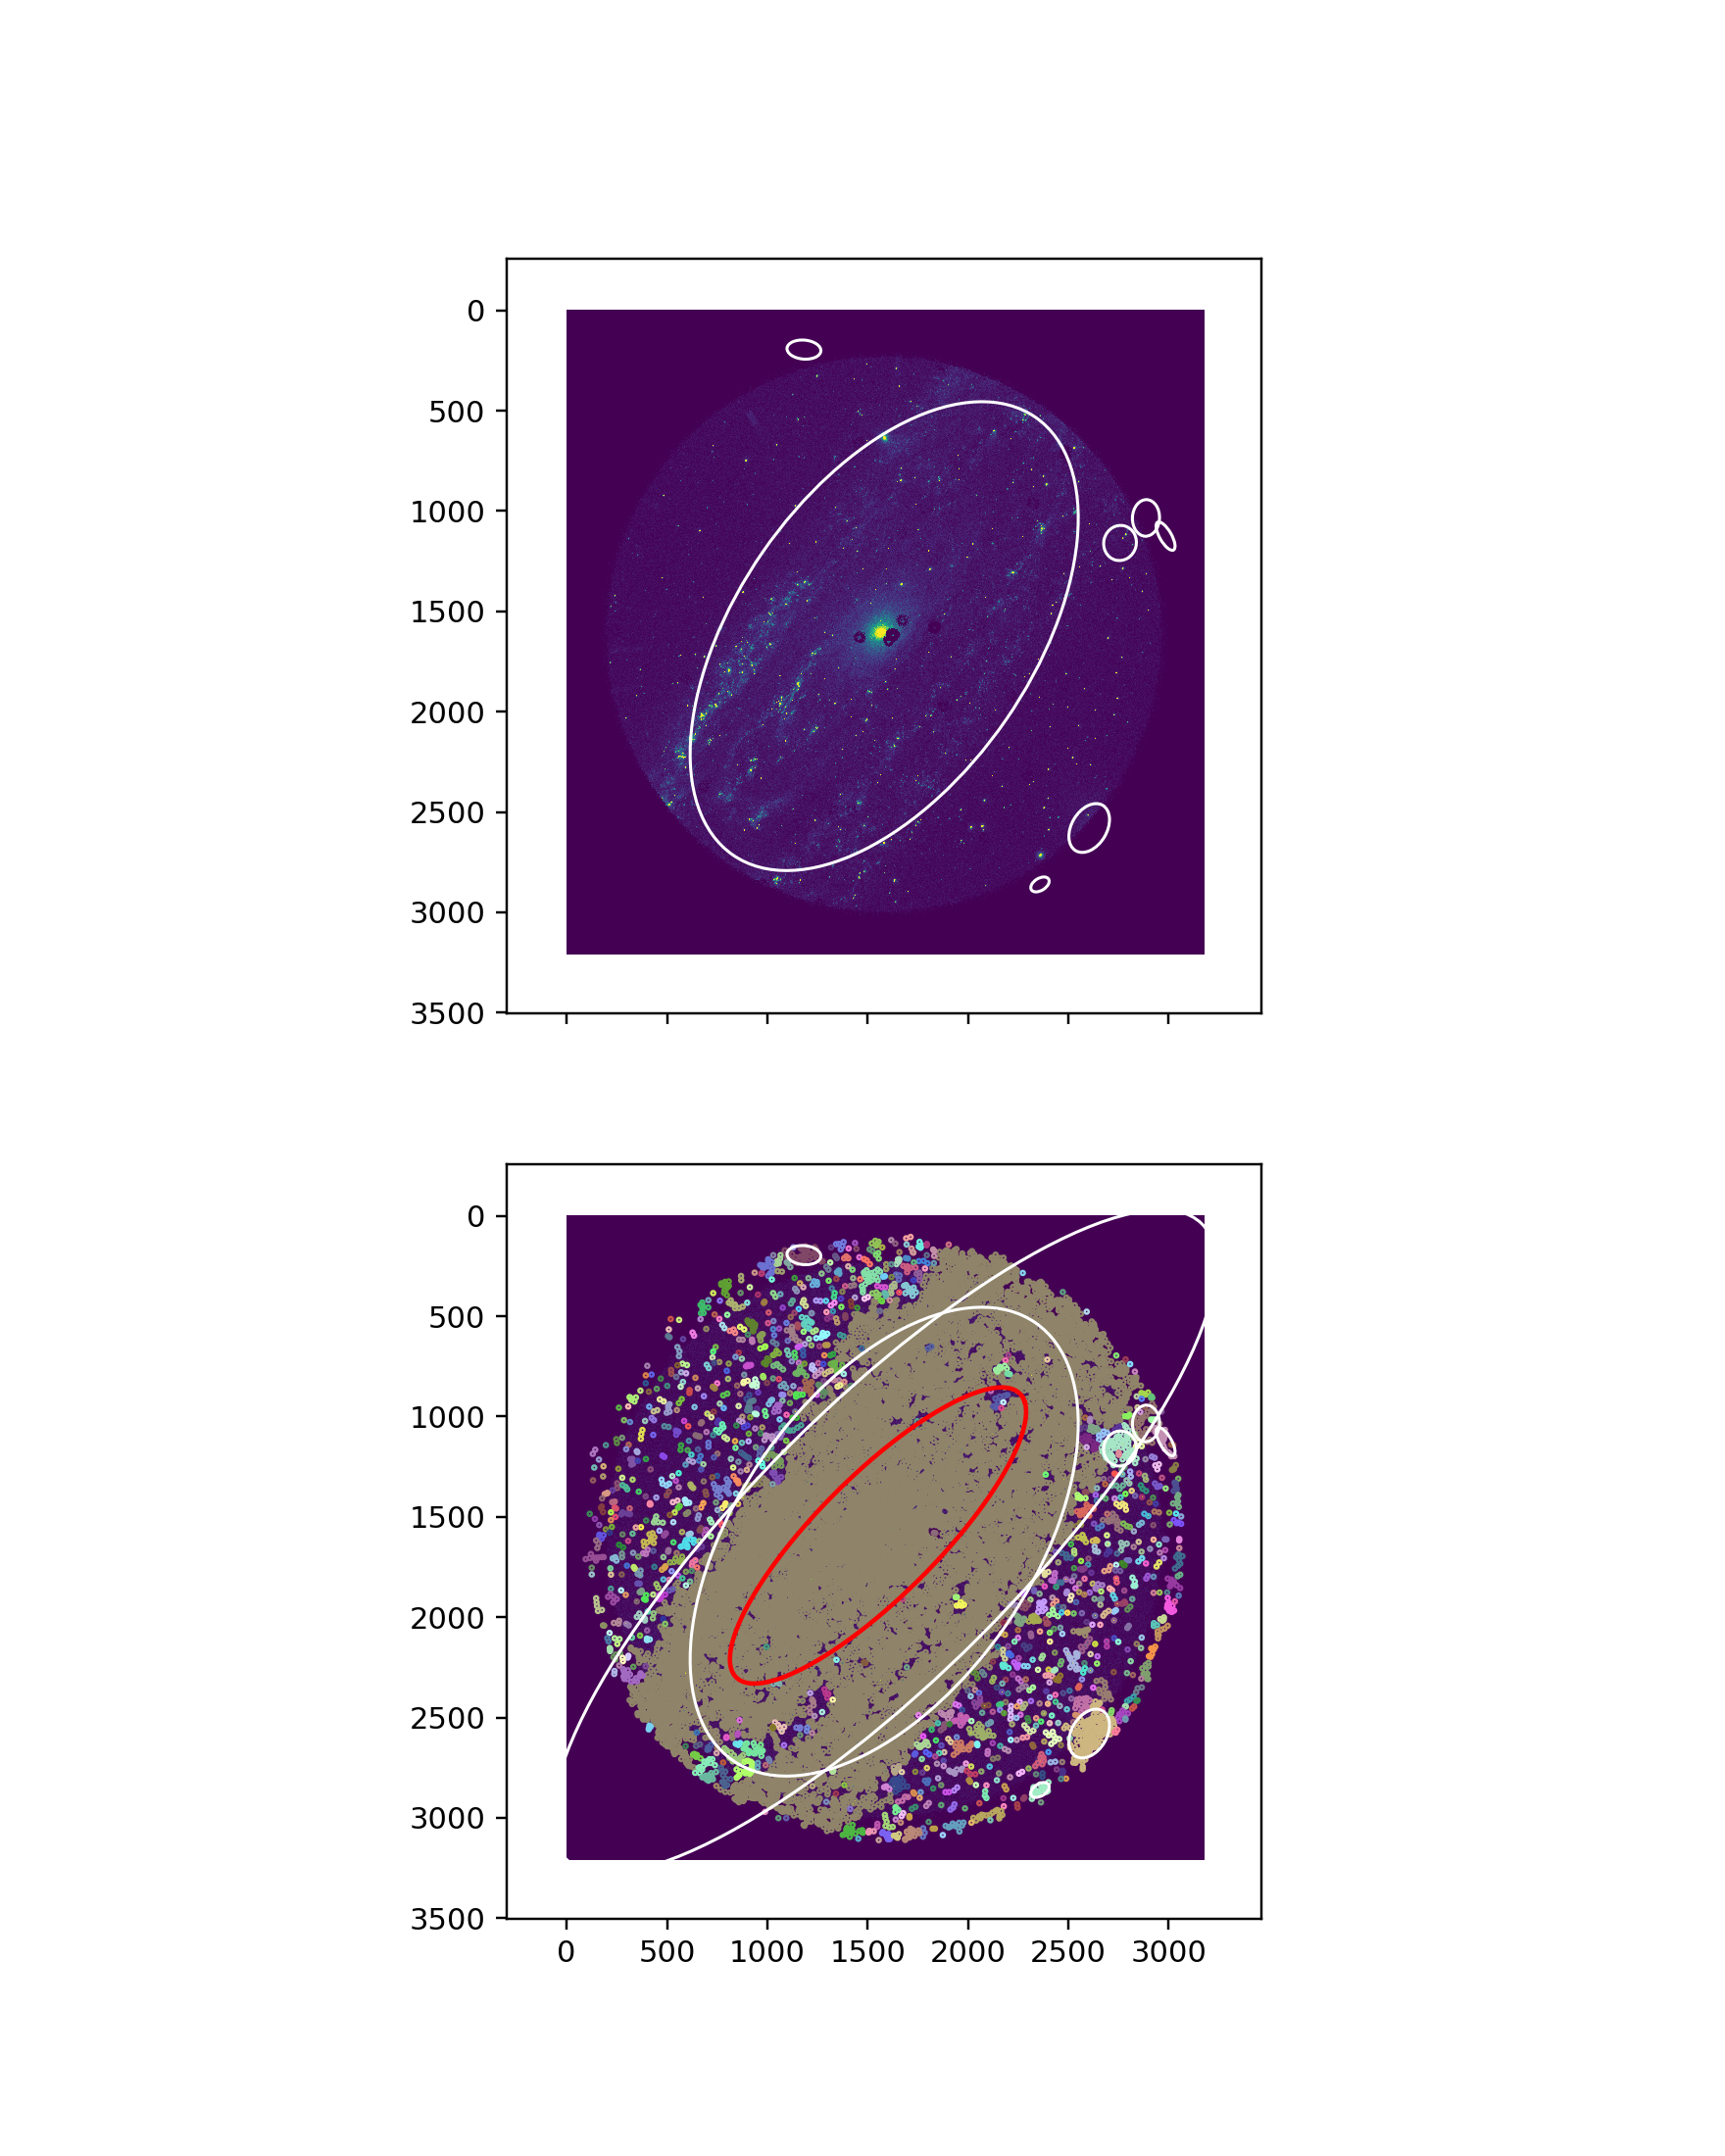

In [6]:
# plotting ellipses for DBSC group

fig, axs = plt.subplots(2, 1,  figsize = (8, 10), sharex=True, sharey=True)

axs[0].imshow(centile_clip(masked_cnt,centiles=(0,99.9)),interpolation='none')

for i in range(len(extended_sources_dbsc)):
    ell_patch = Ellipse((extended_sources_dbsc.loc[i,'xc'], extended_sources_dbsc.loc[i,'yc']), 2*extended_sources_dbsc.loc[i,'a'], 2*extended_sources_dbsc.loc[i,'b'], extended_sources_dbsc.loc[i,'theta']*180/np.pi, edgecolor='white', facecolor='none')
    axs[0].add_patch(ell_patch)
    
axs[1].imshow(centile_clip(masked_cnt,centiles=(0,99.9)),interpolation='none')
cmap = make_random_cmap(ncolors=4000,seed=34)

for i, group in enumerate(dbsc_star_groups.groups):
    xypos = np.transpose([group['x_0'], group['y_0']])
    ap = CircularAperture(xypos, r=fwhm_db)
    ap.plot(color=cmap.colors[i],lw=.8)
    
for i in range(len(extended_sources_dbsc)):
    ell_patch = Ellipse((extended_sources_dbsc.loc[i,'xc'], extended_sources_dbsc.loc[i,'yc']), 2*extended_sources_dbsc.loc[i,'a'], 2*extended_sources_dbsc.loc[i,'b'], extended_sources_dbsc.loc[i,'theta']*180/np.pi, edgecolor='white', facecolor='none')
    axs[1].add_patch(ell_patch)
    
plt.show()

In [7]:
# Elliptical Isophote Stuff 

from photutils.isophote import EllipseGeometry
from photutils.aperture import EllipticalAperture
from photutils.isophote import Ellipse

geometry = EllipseGeometry(x0=1582, y0=1623, sma=2*1120, eps=0.7,
                           pa=-45. / 180. * np.pi)

ellipse = Ellipse(masked_cnt, geometry) # , geometry

isolist = ellipse.fit_isophote(1000)

isolist.to_table()

sma,intens,intens_err,ellipticity,ellipticity_err,pa,pa_err,grad,grad_error,grad_rerror,x0,x0_err,y0,y0_err,ndata,nflag,niter,stop_code
,,,,,deg,deg,,,,,,,,,,,
int64,float64,float64,float64,float64,float64,float64,float64,object,object,float64,float64,float64,float64,int64,int64,int64,int64
1000,7.972290727546114,0.1852972256127554,0.7,0.07147583722306144,-45.0,4.700527497267232,0.0022344468622875055,None,None,1551.7758837243405,78.36351034489296,1592.7758837243405,78.36351034489294,3179,0,2,-1


In [8]:
# Plotting ellipses from isosphote 

aper = EllipticalAperture((geometry.x0, geometry.y0), geometry.sma,
                          geometry.sma * (1 - geometry.eps),
                          geometry.pa)
plt.imshow(centile_clip(masked_cnt,centiles=(0,99.9)),interpolation='none')
aper.plot(color='white')
plt.show()

from photutils.isophote import build_ellipse_model
#model_image = build_ellipse_model(masked_cnt.shape, isolist)
#residual = masked_cnt - model_image

plt.imshow(centile_clip(masked_cnt,centiles=(0,99.9)),interpolation='none')
x, y, = isolist.sampled_coordinates()
plt.plot(x, y, color='red')

In [10]:
from photutils.isophote import EllipseSample, EllipseFitter

sample = EllipseSample(masked_cnt, 1000., geometry=geometry)
fitter = EllipseFitter(sample)
isophote = fitter.fit()

print(isophote)

 sma         intens          intens_err     ... nflag niter stop_code
                                            ...                      
------ ----------------- ------------------ ... ----- ----- ---------
1000.0 7.972290727546114 0.1852972256127554 ...     0     2        -1


In [11]:
isophote.sample.values.shape


(3, 3179)

<IPython.core.display.Javascript object>


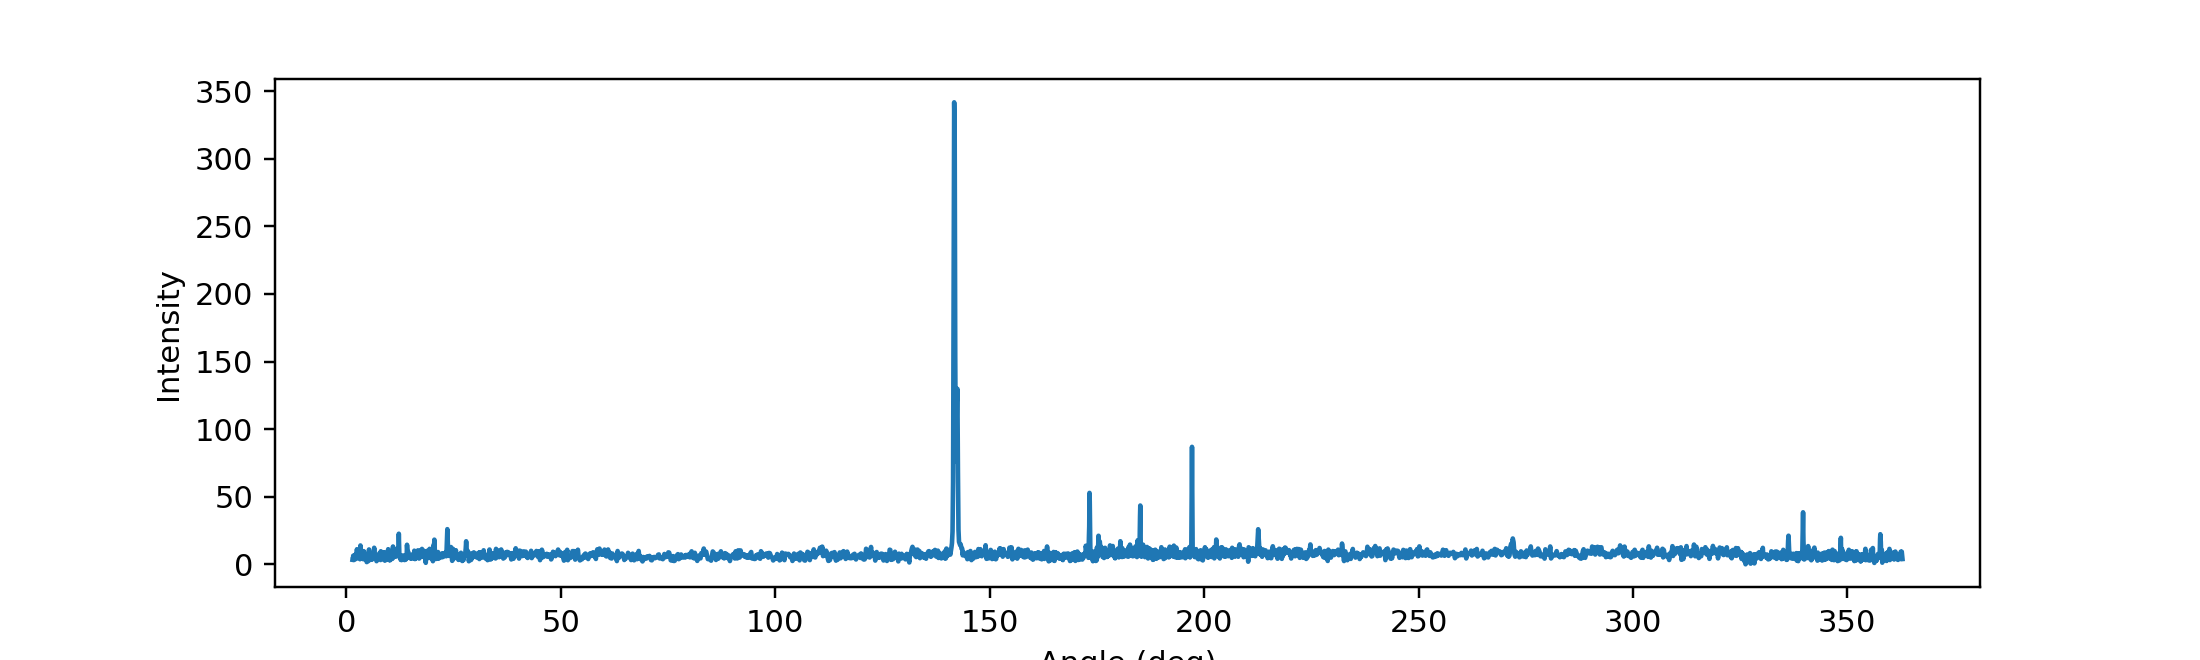

Text(0.5, 0, 'Angle (deg)')

In [15]:

plt.figure(figsize=(10, 3))
plt.plot(isophote.sample.values[0] / np.pi*180., isophote.sample.values[2])
plt.ylabel("Intensity")
plt.xlabel("Angle (deg)")